# Quantitative Stock Selection

In [3]:
import yfinance as yf 

import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import math
from time import sleep
import quandl
import seaborn as sns
import sys
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import sys
import scipy.stats 
import ezodf
import scipy.optimize as sco
import scipy
import re
import os.path

## Functions

In [2]:
# FUNCTIONS FOR VIEWING SINGLE COMPANY RANKINGS 

def company(company):
    for i in data['Company']:
        if company in i or company in i.lower():
            return data.loc[data['Company'] == i]
    print('No company found')
    
def Company(company):
    for i in data['Company']:
        if company in i or company in i.lower():
            stock = data.loc[data['Company'] == i]
            stock = stock[compact]
            return stock
    print('No company found')

In [3]:
def mod_Z_score(data):
    mean = np.mean(data.iloc[:-1])
    deviation_from_med = np.array(data.iloc[:-1]) - mean
    MAD = np.mean(np.abs(deviation_from_med))
    mod_Z = (data[-1:] - mean)/(MAD * 1.4826)
    return mod_Z

## Data Import and Wrangling

In [4]:
# IMPORT LATEST DATA 

path_import = "../equity_data/Borsdata_2021-09-10.xlsx"
data_tmp = pd.read_excel(path_import, sheet_name="Export")
data_tmp = data_tmp[1:]

data_tmp = data_tmp.rename({'Performance - Perform. 3m' : 'Return 3m','Performance - Perform. 6m' : 'Return 6m',
                            'Performance - Perform. 1y' : 'Return 1y',
                            'Div. Yield - Current': 'Yield', 
                            'Total Equity  - Millions':'Total Equity', 'FCF - Millions': 'FCF','ROE - Current':'ROE',
                            'Volatility - St.Dev. 100d':'Volatility','Market Cap - Current': 'Market Cap', 
                            'ROC - Current':'ROC', 'Tot. Assets - Millions':'Tot. Assets', 
                            'Gross profit - Millions':'Gross profit', 'Assets Turn - Current': 'Assets Turn',
                            'P/FCF - Current':'P/FCF', 'P/E - Current':'P/E', 'P/S - Current':'P/S',
                            'P/B - Current':'P/B','EV/EBIT - Current':'EV/EBIT',
                            'Info - Country' : 'Country','F-Score - Point':'F-Score',
                            'Info - List' : 'List', 'Info - Sector' : 'Sector', 'Info - Industry' : 'Industry',
                            'Info - Ticker' : 'Tick', 'Info - Yahoo':'Yahoo', 'Info - Last Report': 'Last Report',
                           'Volume - Average 50d Mill' : 'Volume'}, axis=1)

# FORMAT FOR VIEWING PLEASURE
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

In [5]:
# MAKE NUMBERS FLOATS 

data_tmp['Market Cap'] = data_tmp['Market Cap'].replace(',', '') # remove , as 1000 separator

param_list = ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B', 'Assets Turn', 'Gross profit', 'Tot. Assets', 'ROC', 'Yield', 'Market Cap', 'Volatility',
        'F-Score', 'ROC', 'ROE', 'FCF', 'Total Equity', 
        'Return 3m', 'Return 6m', 'Return 1y']

for i in param_list: 
    data_tmp[i] = pd.to_numeric(data_tmp[i]) # make every number numeric


data_tmp['FCFROE'] = data_tmp['FCF']/data_tmp['Total Equity'] # calc FCFROE
data_tmp['GPA'] = data_tmp['Gross profit']/data_tmp['Tot. Assets'] 

In [6]:
# Manage negativ equity

data_tmp.loc[(data_tmp['Total Equity'] < 0), ['ROE', 'FCFROE', 'P/B']] = np.nan


In [7]:
### FILTER DATA FOR VOLUME, LIST AND MARKET CAP

data_tmp = data_tmp.loc[data_tmp['Market Cap'] > 400] #Market cap filter


data_tmp = data_tmp.loc[ (data_tmp['List'] != 'Spotlight') 
                        & (data_tmp['List'] != 'NGM')]

#Volume Filter
data_tmp = data_tmp.loc[data_tmp['Volume'] > 0.5] 

# Set to dattime
data_tmp['Last Report'] = pd.to_datetime(data_tmp['Last Report'])

#set new index
data_tmp.index = range(len(data_tmp.index))

In [8]:
print("Companies in data: ",len(data_tmp))
print("Missing Report Dates: ",sum(data_tmp['Last Report'].isna()))


Companies in data:  458
Missing Report Dates:  4


In [9]:
### Sector
data_tmp.groupby('Sector').mean()['Return 3m']

Sector
Consumer Durables    0.01
Energy               0.04
Financials           0.11
Food and Beverage    0.03
Health Care          0.19
Industrials          0.14
Materials            0.02
Technology           0.08
Telecom              0.02
Utilities           -0.17
Name: Return 3m, dtype: float64

In [10]:
#data_tmp.groupby("Sector")["Return 3m"].transform('mean')

In [11]:
#data_tmp

In [12]:
data_tmp.groupby('Sector').size()

Sector
Consumer Durables     67
Energy                 8
Financials            79
Food and Beverage     18
Health Care           78
Industrials          103
Materials             23
Technology            63
Telecom                7
Utilities             12
dtype: int64

## Calculate Price Based Data from Yahoo Finance

In [59]:
## Get PEAD
data_tmp["EA ret"] = np.nan
data_tmp["EA ret std"] = np.nan
data_tmp['1 Year Volatility'] = np.nan
data_tmp['1 Year MAD'] = np.nan
data_tmp['1 Month Return'] = np.nan
data_tmp['EA Volatility'] = np.nan
index = yf.download('^OMXSPI',start='2020-01-01', threads = False, progress = False)
index = index['Close']

error_count = 0
error_list = []

In [60]:
for i in range(len(data_tmp)):
    try:
        stock = yf.download(data_tmp.iloc[i]['Yahoo'],start='2020-01-01', progress = False, threads = False)
        stock = stock['Close']
        import_data = pd.concat([stock, index], axis = 1)
        import_data.columns = ['stock', 'index']
        import_data = import_data.dropna()
        
        # get index of date of report
        idx = import_data.index.get_loc(data_tmp.iloc[i]['Last Report'], method='nearest')
        EA_data = import_data.iloc[idx - 2 : idx +2 ]
        
        stock_idx = stock.index.get_loc(data_tmp.iloc[i]['Last Report'], method='nearest')
        
        EA_ret = (EA_data.pct_change().dropna()+1).cumprod().tail(1)
        pead_ret = float(EA_ret['stock'] - EA_ret['index'])
        data_tmp.loc[i,"EA ret"]= pead_ret
        
        data_tmp.loc[i,"1 Month Return"]= float((stock.pct_change().tail(5).dropna()+1).cumprod().tail(1)) - 1
        
        data_tmp.loc[i, 'EA Volatility'] = np.log(stock.iloc[:idx]/stock.iloc[:idx].shift()).tail(60).std()*252**.5 
        #Get MAD of stock
        data_tmp.loc[i,"1 Year MAD"]= np.log(stock/stock.shift()).tail(252).mad()*252**.5*1.25
        # Get volatility of stock
        data_tmp.loc[i,"1 Year Volatility"]= np.log(stock/stock.shift()).tail(252).std()*252**.5 
       
    except:
        #data_tmp.loc[i,"EA ret"]= np.nan
        #print("ERROR! INDEX: ", i, ', TICKER: ', data_tmp.iloc[i]['Yahoo'])
        error_count = error_count + 1
        error_list.append(i)
    
    


1 Failed download:
- SDIP.ST: No data found, symbol may be delisted

1 Failed download:
- ADAPT.ST: No data found, symbol may be delisted


In [61]:
### NA ANALYTICS
print("Amount of Errors: ",error_count )
print("Missing EA rets: ",sum(data_tmp["EA ret"].isna()) )
print("Missing EA volatility: ",sum(data_tmp["EA Volatility"].isna()) )
print("Missing 1 Year volatility: ",sum(data_tmp["1 Year Volatility"].isna()) )

Amount of Errors:  6
Missing EA rets:  6
Missing EA volatility:  6
Missing 1 Year volatility:  6


In [62]:
## Show errors
data_tmp[data_tmp['EA ret'].isna()][['Company', 'Yahoo', 'Last Report', 'EA ret']]

,Company,Yahoo,Last Report,EA ret
74,Stenhus Fastigheter,SFAST.ST,NaT,nan
86,Sdiptech,SDIP.ST,2021-07-23,nan
127,Pfizer,PFE.ST,NaT,nan
269,Smart Wires,GOGRID-SDB.ST,NaT,nan
341,Creaspac SPAC,CPAC-SPAC.ST,NaT,nan
447,Adapteo,ADAPT.ST,2021-08-03,nan


### Test

In [63]:
data_tmp['Sector Mom'] = data_tmp.groupby("Sector")["1 Month Return"].transform('mean')
data_tmp['Ind Rel Ret'] =data_tmp['1 Month Return'] -   data_tmp['Sector Mom']

data_tmp['1m Rank'] = data_tmp['1 Month Return'].rank(ascending = True,pct=True) #high rank means high return
data_tmp['Sector Rank'] = data_tmp['Sector Mom'].rank(ascending = False,pct=True) # Low rank means high return

#comb rank, high is good
#low means strong sector, weak stocks = buy
data_tmp['High Freq Combo'] = (data_tmp['1m Rank'] + data_tmp['Sector Rank']).rank(ascending = False,pct=True) 

In [64]:
d = {'short': [1, 2,3,4], 'long': [4, 1,3,2]}
df = pd.DataFrame(data=d)
df['short rank'] = df['short'].rank(ascending = True,pct=True) 
df['long rank'] = df['long'].rank(ascending = False,pct=True) 
df['comb'] = (df['short rank'] + df['long rank']).rank(ascending = False,pct=True) 


In [65]:
df

,short,long,short rank,long rank,comb
0,1,4,0.25,0.25,1.00
1,2,1,0.50,1.00,0.50
2,3,3,0.75,0.50,0.75
3,4,2,1.00,0.75,0.25


### TESTING TICKERS ONCE AGAIN, RE ENTER FAILED TICKERS BY HAND

In [66]:
##### TESTING TICKERS ONCE AGAIN, RE ENTER FAILED TICKERS BY HAND #####
j = None
if j != None:
    stock = yf.download(data_tmp.iloc[j]['Yahoo'],start='2020-01-01', progress = False, threads = False)
    stock = stock['Close']
    import_data = pd.concat([stock, index], axis = 1)
    import_data.columns = ['stock', 'index']
    import_data = import_data.dropna()

    # get index of date of report
    idx = import_data.index.get_loc(data_tmp.iloc[j]['Last Report'], method='nearest')
    EA_data = import_data.iloc[idx - 2 : idx +2 ]

    stock_idx = stock.index.get_loc(data_tmp.iloc[j]['Last Report'])

    EA_ret = (EA_data.pct_change().dropna()+1).cumprod().tail(1)
    pead_ret = float(EA_ret['stock'] - EA_ret['index'])
    data_tmp.loc[j,"EA ret"]= pead_ret
    data_tmp.loc[j, 'EA Volatility'] = np.log(stock.iloc[:idx]/stock.iloc[:idx].shift()).tail(60).std()*252**.5 
    #Get MAD of stock
    data_tmp.loc[j,"1 Year MAD"]= np.log(stock/stock.shift()).tail(252).mad()*252**.5*1.25
    # Get volatility of stock
    data_tmp.loc[j,"1 Year Volatility"]= np.log(stock/stock.shift()).tail(252).std()*252**.5 

### Handel NANs

In [67]:
# MANAGE NaNs and NEGATIVE EARNINGS  
# set nan to min
for i in ['Return 3m', 'Return 6m', 'Return 1y']:
    data_tmp.loc[data_tmp[i].isna() ,i] = data_tmp[i].min()
    
data_tmp.loc[data_tmp['Volatility'].isna(),'Volatility'] = data_tmp['Volatility'].median()

data_tmp.loc[data_tmp['EA ret'].isna(),'EA ret'] = data_tmp['EA ret'].median()
data_tmp.loc[data_tmp['EA Volatility'].isna(),'EA Volatility'] = data_tmp['Volatility'].median()/100

#Impute 100 day volatility for NANs
data_tmp.loc[data_tmp['1 Year Volatility'].isna(),'1 Year Volatility'] = data_tmp.loc[data_tmp['1 Year Volatility'].isna(),'Volatility']/100

#Impute median for NAN MAD
data_tmp.loc[data_tmp['1 Year MAD'].isna(),'1 Year MAD'] = data_tmp['1 Year MAD'].median()

In [68]:
## Impute EA std and calculate EA STD after everything has been imputed
data_tmp["EA ret std"] = data_tmp["EA ret"]/((data_tmp["EA Volatility"]*np.sqrt(3))/np.sqrt(252))

#Impute median for NAN EA STD
data_tmp.loc[data_tmp['EA ret std'].isna(),'EA ret std'] = data_tmp['EA ret std'].median()

In [69]:
### SAVE cleaned file into a CSV
save = "NO"
if save == "YES":
    data_date  = re.search(r'\d{4}-\d{2}-\d{2}', path_import)
    folder = 'clean_equity_data'
    exp_file_name = "clean_equity_data_{}".format(data_date.group(0))+ ".csv"
    data_tmp.to_csv(os.path.join(folder, exp_file_name))

# DATA handling



In [70]:
####### FILTER DATA FOR SUB STRATEGIES
data_full = data_tmp.copy()
### MOMENTUM
data_mom = data_tmp.copy()
data_mom = data_mom.loc[(data_mom['Industry'] != 'Holding Companies')]
#data_mom = data_tmp.loc[(data_tmp['Sector'] != 'Financials')]

data = data_tmp.copy()
### GESTALT
data = data.loc[(data_tmp['Sector'] != 'Financials')]

## MOMENTUM


In [71]:
# RANK ON DIFFERENT METRICS 

data_mom['3m Rank'] = data_mom['Return 3m'].rank(ascending = False)
data_mom['6m Rank'] = data_mom['Return 6m'].rank(ascending = False)
data_mom['1y Rank'] = data_mom['Return 1y'].rank(ascending = False)
data_mom['EA Rank'] = data_mom['EA ret'].rank(ascending = False)
data_mom['EA Std Rank'] = data_mom['EA ret std'].rank(ascending = False)
data_mom['Volatility Rank'] = data_mom['1 Year Volatility'].rank(ascending = True)
data_mom['MAD Rank'] = data_mom['1 Year Volatility'].rank(ascending = True)

# MOMENTUM WITH VOLATILITY
#data_mom['Momentum Rank'] = (data_mom['Return 3m'].rank(ascending = False) + data_mom['Return 6m'].rank(ascending = False) + 
#                              data_mom['Return 1y'].rank(ascending = False) + data_mom['Volatility'].rank(ascending = True)).rank(ascending = True)

# PURE MOMENTUM
#data_mom['Momentum Rank'] = (data_mom['Return 3m'].rank(ascending = False) + data_mom['Return 6m'].rank(ascending = False) + 
#                              data_mom['Return 1y'].rank(ascending = False)).rank(ascending = True)

# MOMENTUM WITH WOLATILITY AND EA
data_mom['Momentum Rank'] = (data_mom['3m Rank'] + data_mom['6m Rank'] +  data_mom['1y Rank'] + data_mom['Volatility Rank'] + data_mom['EA Std Rank']).rank(ascending = True)

## GESTALT

In [72]:
# MANAGE NaNs and NEGATIVE EARNINGS  

# set nan to median, only fundamental data
columns = ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B', 'ROC', 'ROE',
           'F-Score', 'GPA', 'Assets Turn', 'FCFROE']
for i in columns: 
    data.loc[data[i].isna() ,i] = data[i].median()

# set nan to min
#for i in ['Return 3m', 'Return 6m', 'Return 1y']:
#    data.loc[data[i].isna() ,i] = data[i].min()
    
# set negative values to max
for i in ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B']:
    data.loc[data[i] < 0 ,i] = data[i].max()
    
# set nan yield & vol to 0
data.loc[data['Yield'].isna(),'Yield'] = 0

In [73]:
#data_mom.isna().sum()

### Test

In [74]:
data['1m Rank'] = data['1 Month Return'].rank(ascending = True,pct=True) #high rank means high return
data['Sector Rank'] = data['Sector Mom'].rank(ascending = False,pct=True) # Low rank means high return

#comb rank, high is good

#low means strong sector, weak stocks = buy
data['High Freq Combo'] = (data['1m Rank'] + data['Sector Rank']).rank(ascending = False,pct=True) 

## Rankings and Sorting

In [75]:
# RANK ON DIFFERENT METRICS 


data['3m Rank'] = data['Return 3m'].rank(ascending = False)
data['6m Rank'] = data['Return 6m'].rank(ascending = False)
data['1y Rank'] = data['Return 1y'].rank(ascending = False)
data['EA Rank'] = data['EA ret'].rank(ascending = False)
data['EA Std Rank'] = data['EA ret std'].rank(ascending = False)


data['Momentum Rank'] = (data['3m Rank'] + data['6m Rank'] + data['1y Rank'] + data['EA Std Rank']).rank(ascending = True)

#data['Momentum'] = (data['Return 3m'] + data['Return 6m'] + data['Return 1y'])

# Ranking where lower value is better
for i in ['P/E', 'P/B', 'P/S', 'P/FCF', 'EV/EBIT']:
    data[i +' Rank'] = data[i].rank()
    
# Ranking where higher value is better
#for i in ['Yield', 'ROE', 'ROC', 'FCFROE', 'Momentum', 'GPA', 'Assets Turn']:
for i in ['Yield', 'ROE', 'ROC', 'FCFROE', 'GPA', 'Assets Turn']:
    data[i + ' Rank'] = (-data[i]).rank()
    
# Composite ranks
data['Quality Rank'] = (data['ROE Rank'] + data['ROC Rank'] + data['FCFROE Rank'] + 
                        data['GPA Rank'] + data['Assets Turn Rank']).rank()
data['Value Rank'] = (data['P/E Rank'] + data['P/B Rank'] + data['P/S Rank'] + data['P/FCF Rank'] + 
                      data['EV/EBIT Rank'] + data['Yield Rank']).rank()
 
data['Magic Formula'] = (data['ROC Rank'] + data['EV/EBIT Rank']).rank()
data['Siegfrieds'] = (data['ROC Rank'] + data['P/B Rank']).rank()
data['Triple Sort'] = ((data['Value Rank'] + data['Momentum Rank'] + data['Quality Rank'])).rank()
data['Double Sort'] = (data['Value Rank'] + data['Quality Rank']).rank()

In [76]:
# SORTING 

# number of stocks to choose before momentum screen
trend_screen = 40
double_sort_break_off = 40

value_tmp = data.sort_values(by=['Value Rank'])
quality_tmp = data.sort_values(by=['Quality Rank'])
#### MOMENTUM DATA FRAME
momentum_tmp = data_mom.sort_values(by=['Momentum Rank'])


trending_value_tmp = value_tmp[0:trend_screen]
trending_value_tmp = trending_value_tmp.sort_values(by='Momentum Rank')
trending_quality_tmp = quality_tmp[0:trend_screen]
trending_quality_tmp = trending_quality_tmp.sort_values(by='Momentum Rank')
magic_formula_tmp = data.sort_values(by=['Magic Formula'])
siegfrieds_tmp = data.sort_values(by=['Siegfrieds'])
triple_sort_tmp = data.sort_values(by=['Triple Sort'])
double_sort = data.sort_values(by=['Double Sort'])
double_sort_mom_tmp = double_sort[0:double_sort_break_off]
double_sort_mom = double_sort_mom_tmp.sort_values(by=['Momentum Rank'])

In [77]:
# FACTOR STRATEGIES 

compact = ['Company', 'List','Tick', 'Quality Rank', 'Value Rank', 'Momentum Rank', 'EA Std Rank', '1 Year Volatility', 'High Freq Combo']
compact_mom = ['Company', 'List','Tick', 'Momentum Rank','Volatility Rank','EA Std Rank', '1 Year Volatility', 'High Freq Combo']

# numbers of stocks to select for diff strategies

stocks = 20
magic_formula_stocks = 10
siegfried_stocks = 10
triple_sort_stocks = 20
double_sort_mom_stocks = 10

## VALUE ## 
value = value_tmp[0:stocks]
Value = value[compact]

## QUALITY ## 
quality = quality_tmp[0:stocks]
Quality = quality[compact]

## MOMENTUM ##
momentum = momentum_tmp[0:stocks]
Momentum = momentum[compact_mom]

## TRENDING VALUE ##
trending_value = trending_value_tmp[0:stocks]
Trending_Value = trending_value[compact]

## TRENDING QUALITY ##
trending_quality = trending_quality_tmp[0:stocks]
Trending_Quality = trending_quality[compact]

## MAGIC FORMULA ##
magic_formula = magic_formula_tmp[0:magic_formula_stocks]
Magic_Formula = magic_formula[compact]

## SIEGFRIEDS ##
siegfrieds = siegfrieds_tmp[0:siegfried_stocks]
Siegfrieds = siegfrieds[compact]

## TRIPLE SORT ##
triple_sort = triple_sort_tmp[0:triple_sort_stocks]
Triple_Sort = triple_sort[compact]

## DOUBLE SORT + Momentum ##
double_sort_mom = double_sort_mom[0:double_sort_mom_stocks]
Double_Sort_Mom = double_sort_mom[compact]

In [78]:
company('Nil')

,Börsdata ID,Company,Volume,Yahoo,Last Report,EV/EBIT,Tick,Industry,List,Country,Return 1y,Return 6m,Return 3m,Total Equity,FCF,ROE,F-Score,Volatility,Market Cap,ROC,Tot. Assets,Gross profit,Assets Turn,P/FCF,Info - Ticker.1,Yield,P/E,P/S,P/B,Sector,FCFROE,GPA,EA ret,EA ret std,1 Year Volatility,1 Year MAD,1 Month Return,EA Volatility,Sector Mom,Ind Rel Ret,1m Rank,Sector Rank,High Freq Combo,3m Rank,6m Rank,1y Rank,EA Rank,EA Std Rank,Momentum Rank,P/E Rank,P/B Rank,P/S Rank,P/FCF Rank,EV/EBIT Rank,Yield Rank,ROE Rank,ROC Rank,FCFROE Rank,GPA Rank,Assets Turn Rank,Quality Rank,Value Rank,Magic Formula,Siegfrieds,Triple Sort,Double Sort
154,758,Nilörngruppen,1.85,NIL-B.ST,2021-07-16,8.52,NIL B,Packaging,Small Cap,Sweden,0.85,0.26,-0.07,224.73,86.58,0.29,7.00,35.14,778.76,0.45,457.03,310.05,1.47,8.99,NIL B,0.03,11.93,1.16,3.46,Materials,0.39,0.68,-0.16,-5.09,0.40,0.30,-0.05,0.28,-0.02,-0.04,0.11,0.95,0.50,260.00,122.00,89.00,367.00,373.00,210.00,27.00,155.00,72.00,40.00,18.00,45.00,30.00,20.00,34.00,30.00,33.00,9.00,20.50,6.00,19.50,26.50,2.00


## Print Stock Selection

In [79]:
#Triple_Sort 
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]
# Set CSS properties for td elements in dataframe
td_props = [('font-size', '12px'), ('text-align', 'center')]
#set caption props
caption_props = [('color', 'black'),('font-size', '22px'),
        ("text-align", "center"),
        ('font-weight', 'bold')]
# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props),
    dict(selector="caption", props=caption_props)
]
Triple_Sort.index = range(1, len(Triple_Sort)+1)
Triple_Sort_view = (Triple_Sort.style.apply(lambda x: ['background: lightgreen' if x.name in range(1, 10+1) 
                              else '' for i in x], axis=1).set_table_styles(styles)
                 .format({'1 Year Volatility': "{:.1%}"})
                 .set_caption("Gestalt"))
Triple_Sort_view

,Company,List,Tick,Quality Rank,Value Rank,Momentum Rank,EA Std Rank,1 Year Volatility,High Freq Combo
1,Dedicare,Small Cap,DEDI,5,49.5,18,28,37.3%,0.619681
2,BE Group,Small Cap,BEGR,68,16,2,12,46.8%,0.625
3,Björn Borg,Small Cap,BORG,29,44,23,89,34.4%,0.406915
4,Transtema,First North,TRANS,4,108,10,44,43.0%,0.486702
5,Poolia,Small Cap,POOL B,46,36.5,41,117,44.7%,0.417553
6,Novotek,Small Cap,NTEK B,12,77.5,36.5,6,40.1%,0.273936
7,Bergs Timber,Small Cap,BRG B,37.5,1,90,105,50.0%,0.135638
8,B3 Consulting,Small Cap,B3,31,67,49.5,29,40.4%,0.324468
9,Firefly,First North,FIRE,10,93.5,47,25,32.8%,0.444149
10,Ferronordic,Mid Cap,FNM,24,30,104.5,41,36.3%,0.691489


In [80]:
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]
# Set CSS properties for td elements in dataframe
td_props = [('font-size', '12px'), ('text-align', 'center')]
#set caption props
caption_props = [('color', 'black'),('font-size', '22px'),
        ("text-align", "center"),
        ('font-weight', 'bold')]
# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props),
    dict(selector="caption", props=caption_props)
]
Momentum.index = range(1,len(Momentum)+1)
Momentum_view = (Momentum.style.apply(lambda x: ['background: lightgreen' if x.name in range(1,10+1) 
                              else '' for i in x], axis=1).set_table_styles(styles).format({'1 Year Volatility': "{:.1%}"})
                 .set_caption("Focused Momentum"))
Momentum_view

,Company,List,Tick,Momentum Rank,Volatility Rank,EA Std Rank,1 Year Volatility,High Freq Combo
1,NIBE,Large Cap,NIBE B,1,110,24,30.3%,0.670354
2,Alcadon Group,First North,ALCA,2,208,6,38.0%,0.210177
3,Arjo,Large Cap,ARJO B,3,120,36,31.4%,0.951327
4,Vitrolife,Large Cap,VITR,4,181,57,36.8%,0.630531
5,Samhällsbyggnadsbolag B,Large Cap,SBB B,5,73,103,26.8%,0.232301
6,BE Group,Small Cap,BEGR,6,278,14,46.8%,0.590708
7,Björn Borg,Small Cap,BORG,7,148,104,34.4%,0.517699
8,Getinge,Large Cap,GETI B,8.5,70,54,26.5%,0.920354
9,Dedicare,Small Cap,DEDI,8.5,193,30,37.3%,0.586283
10,Hexatronic,Mid Cap,HTRO,10.5,325,17,52.7%,0.502212


In [35]:
company('Evolution')

,Börsdata ID,Company,Volume,Yahoo,Last Report,EV/EBIT,Tick,Industry,List,Country,Return 1y,Return 6m,Return 3m,Total Equity,FCF,ROE,F-Score,Volatility,Market Cap,ROC,Tot. Assets,Gross profit,Assets Turn,P/FCF,Info - Ticker.1,Yield,P/E,P/S,P/B,Sector,FCFROE,GPA,EA ret,EA ret std,1 Year Volatility,1 Year MAD,1 Month Return,EA Volatility,Sector Mom,Ind Rel Ret,1m Rank,Sector Rank,High Freq Combo,3m Rank,6m Rank,1y Rank,EA Rank,EA Std Rank,Momentum Rank,P/E Rank,P/B Rank,P/S Rank,P/FCF Rank,EV/EBIT Rank,Yield Rank,ROE Rank,ROC Rank,FCFROE Rank,GPA Rank,Assets Turn Rank,Quality Rank,Value Rank,Magic Formula,Siegfrieds,Triple Sort,Double Sort
301,750,Evolution,954.01,EVO.ST,2021-07-21,64.62,EVO,Gambling & Casinos,Large Cap,Sweden,1.58,0.40,-0.06,"31,151.86","3,230.02",0.14,4.00,53.86,"312,460.41",0.16,"36,150.66","6,610.48",0.23,96.74,EVO,0.00,69.29,37.33,10.03,Consumer Durables,0.10,0.18,0.00,0.04,0.47,0.43,-0.04,0.62,0.08,-0.12,0.27,0.09,0.94,257.00,82.00,29.00,175.00,174.00,111.00,193.00,303.00,329.00,183.00,219.00,143.00,115.00,111.00,151.00,242.00,303.00,186.50,229.00,180.50,244.50,186.00,218.00


In [36]:
#data.sort_values(by=['Momentum Rank'])

## Data Illustartion

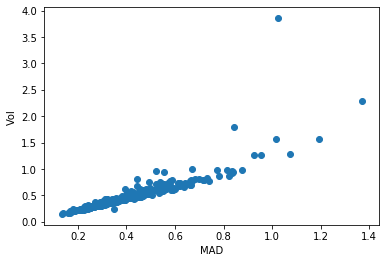

In [32]:
plt.scatter(data['1 Year MAD'],data['1 Year Volatility']);
plt.xlabel('MAD');
plt.ylabel('Vol');

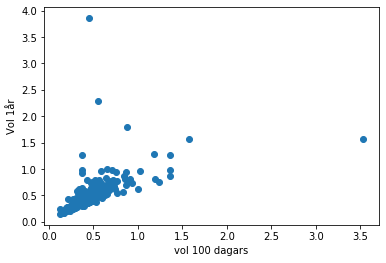

In [34]:
plt.scatter(data['Volatility']/100,data['1 Year Volatility']);
plt.xlabel('vol 100 dagars');
plt.ylabel('Vol 1år');

In [35]:
data[['1 Year MAD', '1 Year Volatility']].corr()

,1 Year MAD,1 Year Volatility
1 Year MAD,1.00,0.86
1 Year Volatility,0.86,1.00


In [36]:
data_mom.sort_values(by='1 Year Volatility')[['Company','1 Year MAD', '1 Year Volatility' ]]

,Company,1 Year MAD,1 Year Volatility
281,Fastpartner D,0.08,0.09
342,Corem D,0.10,0.10
413,Axfood,0.13,0.14
38,Telia Company,0.14,0.16
350,Cloetta,0.16,0.17
455,AAK,0.17,0.17
302,Essity B,0.17,0.18
323,Eastnine,0.18,0.19
39,Tele2 B,0.17,0.19
352,Cibus Nordic,0.17,0.20


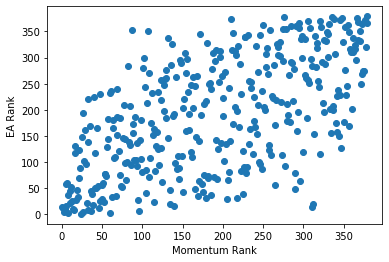

In [40]:
plt.scatter(data['Momentum Rank'],data['EA Std Rank']);
plt.xlabel('Momentum Rank');
plt.ylabel('EA Rank');

#### Correlation heat map between selected Ranks

In [45]:
#corr = data_mom[['3m Rank', '6m Rank', '1y Rank' , 'Momentum Rank', 'EA Std Rank', 'Volatility Rank']].corr()

corr = data[['Quality Rank', 'Value Rank', 'Momentum Rank', 'EA Std Rank', 'Triple Sort']].corr()

In [46]:
corr

,Quality Rank,Value Rank,Momentum Rank,EA Std Rank,Triple Sort
Quality Rank,1.00,0.73,0.23,0.18,0.87
Value Rank,0.73,1.00,0.06,0.04,0.79
Momentum Rank,0.23,0.06,1.00,0.61,0.57
EA Std Rank,0.18,0.04,0.61,1.00,0.36
Triple Sort,0.87,0.79,0.57,0.36,1.00


## Import data

In [4]:
file_name =  "clean_data_2021-11-29.csv"
folder = "../clean_equity_data/"
data_tmp = pd.read_csv(folder + file_name)

In [5]:
data_tmp.sort_values(by='EA ret std')[['Company', 'EA ret std']].head(20)

,Company,EA ret std
375,Sinch,-5.787082
284,Mycronic,-5.160050
289,Nelly Group,-5.157794
240,Kancera,-4.734334
3,ABB,-4.414413
60,BHG Group,-4.398742
139,Eltel,-4.364742
61,BICO Group,-4.344346
125,Dometic,-4.096204
304,Nordic Waterproofing,-4.075908


In [13]:
data_tmp[['EA ret std', 'Return 3m', 'Return 6m' , 'Return 1y']].corr(method = 'spearman')


,EA ret std,Return 3m,Return 6m,Return 1y
EA ret std,1.000000,0.390557,0.253126,0.136902
Return 3m,0.390557,1.000000,0.729948,0.579581
Return 6m,0.253126,0.729948,1.000000,0.787910
Return 1y,0.136902,0.579581,0.787910,1.000000
